# Generative adversarial networks

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model

from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.datasets import mnist, cifar10

Using TensorFlow backend.


## Import data

In [2]:
from sklearn.model_selection import train_test_split

mode = 'two-class'
acquisition = 'raw'

x_train = np.load('./x_train_%s_%s.npy' % (acquisition, mode))[:, :, :, np.newaxis]
y_train = np.load('./y_train_%s_%s.npy' % (acquisition, mode))

random_state = 42

x_train, x_test, y_train, y_test = train_test_split(x_train,
                                                    y_train,
                                                    test_size=0.1,
                                                    random_state=random_state)

# filter out background crops
idx = np.argmax(y_train[:, :3], axis=1) != 0
x_train = x_train[idx]
x_train = 2 * x_train - 1
y_train = np.argmax(y_train[idx, 1:3], axis=1)

idx = np.argmax(y_test[:, :3], axis=1) != 0
x_test = x_test[idx]
x_test = 2 * x_test - 1
y_test = np.argmax(y_test[idx, 1:3], axis=1)

nb_classes = 2

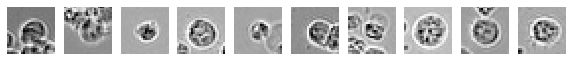

In [3]:
fig = plt.figure(figsize=(10, 3))

nb_samples = 10

for i in range(nb_samples):
    idx = np.random.randint(x_train.shape[0])
    ax = fig.add_subplot(1, nb_samples, i + 1)
    ax.imshow(x_train[idx].squeeze(), cmap='Greys_r')
    ax.axis('off')

## Load model

In [4]:
from src.utils import set_trainable
from src.models import GAN, DCGAN, CGAN, CDCGAN

nb_epochs = 50
batch_size = 120

noise_dim = 100
gen_noise = np.random.randn(10 * nb_classes, noise_dim)

adam = Adam(lr=0.0002, beta_1=0.5, decay=1e-6)

model = 'dcgan'

def get_models(model):

    if model == 'gan':
        return GAN(x_train.shape[1:], noise_dim)
    elif model == 'dcgan':
        return DCGAN(x_train.shape[1:], noise_dim)
    elif model == 'cgan':
        return CGAN(x_train.shape[1:], noise_dim, nb_classes)
    else:
        return CDCGAN(x_train.shape[1:], noise_dim, nb_classes)

def arrange_inputs(model, x, y):
    if model == 'gan' or model == 'dcgan':
        return x
    else:
        return [x, y]
    
generator, discriminator = get_models(model)

discriminator.compile(loss='binary_crossentropy', optimizer=adam)
set_trainable(discriminator, False)

# Create end-to-end model
if model == 'gan' or model == 'dcgan':

    input_noise = Input(shape=(noise_dim,))

    x = generator(input_noise)
    d_output = discriminator(x)

    gan = Model(inputs=input_noise, outputs=d_output)
    gan.compile(loss='binary_crossentropy', optimizer=adam)

else:
    input_noise = Input(shape=(noise_dim,))
    y_input = Input((nb_classes,))

    x = generator([input_noise, y_input])
    d_output = discriminator([x, y_input])

    gan = Model(inputs=[input_noise, y_input], outputs=d_output)
    gan.compile(loss='binary_crossentropy', optimizer=adam)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Train model

In [5]:
from keras.utils import to_categorical
from src.utils import gen_balanced

nb_batch = x_train.shape[0] // batch_size

train_gen = gen_balanced(x_train, to_categorical(y_train, nb_classes), batch_size // 2)


for epoch in range(nb_epochs):

    for _ in range(nb_batch):

        # Get a random set of input noise and images
        noise = np.random.randn(batch_size // 2, noise_dim)

        x_batch, y_batch = next(train_gen)

        # Generate fake images
        g_batch = generator.predict(arrange_inputs(model, noise, y_batch))  # HERE

        x_batch = np.concatenate([x_batch, g_batch])
        y_batch = np.concatenate([y_batch, y_batch])

        # Labels for generated and real data
        d_batch = np.hstack([0.7 + 0.5 * np.random.rand(batch_size // 2),
                             0.3 * np.random.rand(batch_size // 2)])

        # Train discriminator
        set_trainable(discriminator, True)
        loss_d = discriminator.train_on_batch(arrange_inputs(model, x_batch, y_batch), d_batch)  # HERE

        # Train generator
        noise = np.random.randn(batch_size, noise_dim)
        d_batch = np.ones(batch_size)

        set_trainable(discriminator, False)
        loss_g = gan.train_on_batch(arrange_inputs(model, noise, y_batch), d_batch)  # HERE

    print('Epoch %d : %.04f %.04f' % (epoch, loss_d, loss_g))

    gen_y = np.repeat(to_categorical(np.arange(nb_classes)), 10, axis=0)
    samples = generator.predict(arrange_inputs(model, gen_noise, gen_y))  # HERE

    fig = plt.figure(figsize=(10, nb_classes))

    for i in range(samples.shape[0]):
        ax = fig.add_subplot(nb_classes, 10, i + 1)
        ax.imshow(samples[i].squeeze(), cmap='Greys_r')
        ax.axis('off')

    fig.savefig('outputs/%s_%04d.pdf' % (model, epoch), bbox_inches='tight')
    plt.close()
    
generator.save_weights('./weights/%s.h5' % model)


Epoch 0 : 0.5144 0.9031
Epoch 1 : 0.4068 0.5008
Epoch 2 : 0.4541 1.1773
Epoch 3 : 0.5161 1.0117
Epoch 4 : 0.5464 0.8789
Epoch 5 : 0.5113 1.4562
Epoch 6 : 0.4558 1.7793
Epoch 7 : 0.4938 1.6874
Epoch 8 : 0.4989 1.0185
Epoch 9 : 0.4716 1.1256
Epoch 10 : 0.5147 1.0078
Epoch 11 : 0.4629 1.1277
Epoch 12 : 0.5709 0.8915
Epoch 13 : 0.4840 1.5220
Epoch 14 : 0.5306 1.1146
Epoch 15 : 0.4785 1.0451
Epoch 16 : 0.5544 1.1896
Epoch 17 : 0.5698 0.9206
Epoch 18 : 0.6042 0.8049
Epoch 19 : 0.6715 0.8007
Epoch 20 : 0.6989 0.6250
Epoch 21 : 0.5837 0.7337
Epoch 22 : 0.6598 0.9243
Epoch 23 : 0.6195 0.9018
Epoch 24 : 0.6522 0.7874
Epoch 25 : 0.5974 0.7384
Epoch 26 : 0.6220 0.8533
Epoch 27 : 0.6379 0.9916
Epoch 28 : 0.6230 0.6399
Epoch 29 : 0.6326 0.8418
Epoch 30 : 0.6714 0.8417
Epoch 31 : 0.5748 0.7680
Epoch 32 : 0.5589 0.7072
Epoch 33 : 0.5863 0.8136
Epoch 34 : 0.5956 0.8164
Epoch 35 : 0.6457 1.1375
Epoch 36 : 0.6043 0.9671
Epoch 37 : 0.5548 0.8335
Epoch 38 : 0.5966 0.8259
Epoch 39 : 0.6066 0.8352
Epoch 40 

## Sample outputs

### GAN

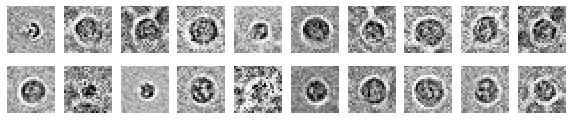

In [6]:
model = 'gan'

generator, _ = get_models(model)
generator.load_weights('./weights/%s.h5' % model)

gen_y = np.repeat(to_categorical(np.arange(nb_classes)), 10, axis=0)
samples = generator.predict(arrange_inputs(model, gen_noise, gen_y))

fig = plt.figure(figsize=(10, nb_classes))

for i in range(samples.shape[0]):
    ax = fig.add_subplot(nb_classes, 10, i + 1)
    ax.imshow(samples[i].squeeze(), cmap='Greys_r')
    ax.axis('off')

### DCGAN

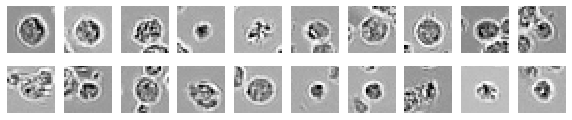

In [7]:
model = 'dcgan'

generator, _ = get_models(model)
generator.load_weights('./weights/%s.h5' % model)

gen_y = np.repeat(to_categorical(np.arange(nb_classes)), 10, axis=0)
samples = generator.predict(arrange_inputs(model, gen_noise, gen_y))

fig = plt.figure(figsize=(10, nb_classes))

for i in range(samples.shape[0]):
    ax = fig.add_subplot(nb_classes, 10, i + 1)
    ax.imshow(samples[i].squeeze(), cmap='Greys_r')
    ax.axis('off')

### CGAN

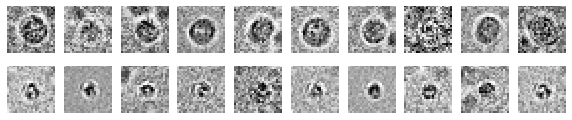

In [8]:
model = 'cgan'

generator, _ = get_models(model)
generator.load_weights('./weights/%s.h5' % model)

gen_y = np.repeat(to_categorical(np.arange(nb_classes)), 10, axis=0)
samples = generator.predict(arrange_inputs(model, gen_noise, gen_y))

fig = plt.figure(figsize=(10, nb_classes))

for i in range(samples.shape[0]):
    ax = fig.add_subplot(nb_classes, 10, i + 1)
    ax.imshow(samples[i].squeeze(), cmap='Greys_r')
    ax.axis('off')

### CDCGAN

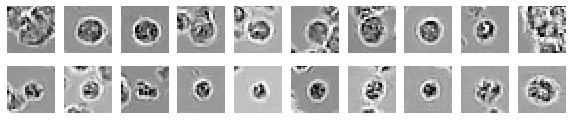

In [9]:
model = 'cdcgan'

generator, _ = get_models(model)
generator.load_weights('./weights/%s.h5' % model)

gen_y = np.repeat(to_categorical(np.arange(nb_classes)), 10, axis=0)
samples = generator.predict(arrange_inputs(model, gen_noise, gen_y))

fig = plt.figure(figsize=(10, nb_classes))

for i in range(samples.shape[0]):
    ax = fig.add_subplot(nb_classes, 10, i + 1)
    ax.imshow(samples[i].squeeze(), cmap='Greys_r')
    ax.axis('off')